In [1]:
import torch 
import torch.nn as nn 
import torchvision 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from tqdm import tqdm 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
import os 
import yaml 

from src import Convolution_Auto_Encoder, Mnist_Dataset,MVtecADDataset,Datadir_init
from src import MVtecEncoder,MVtecDecoder,Convolution_Auto_Encoder

cfg = {'seed':42,
       'img_size':256,
       'device':'cuda:0',
       'encoded_space_dim':128,
       'lr':0.0001,
       'weight_decay':1e-05,
       'batch_size':64,
       'Epochs':100,
       'target_class':6,
       'save_dir':'Base',
       'Dataset_dir':'./Dataset/hazelnut'}

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model 

Text(0.5, 1.0, 'Original Image')

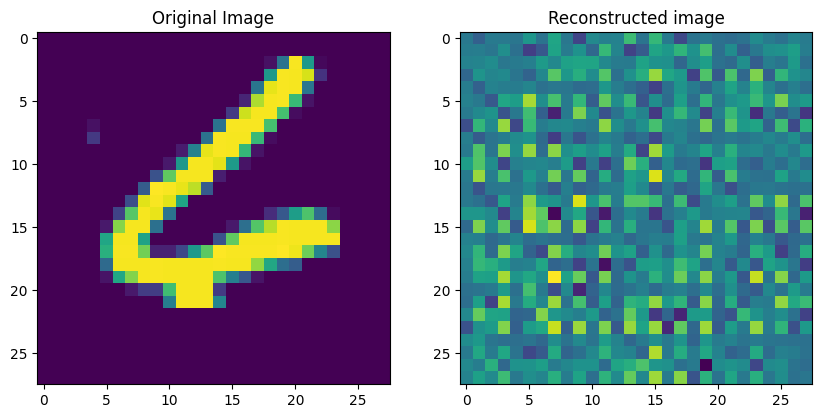

In [15]:
model = Convolution_Auto_Encoder(128)
img,b = next(iter(train_loader))

y_pred= model(img)

y_pred = y_pred.detach().numpy()[1]
y_pred = np.swapaxes(y_pred,0,2)

fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(10, 10))
ax2.imshow(y_pred)
ax2.set_title('Reconstructed image')
ax1.imshow(img[1].permute(1,2,0).numpy())
ax1.set_title('Original Image')

# 학습 

In [4]:
def preprocess(cfg):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['save_dir']}")
    except:
        pass

    #seed fix 
    torch.manual_seed(cfg['seed'])
    # download path 정의
    download_root = './MNIST_DATASET'

    train_dataset = MNIST(download_root, train=True, download=True)
    valid_dataset = MNIST(download_root, train=False, download=True)


    train_loader = DataLoader(Mnist_Dataset(train_dataset,target_class=cfg['target_class']),cfg['batch_size'],shuffle=True)
    valid_normal_loader = DataLoader(Mnist_Dataset(valid_dataset,target_class=cfg['target_class']),cfg['batch_size'])
    valid_anomal_loader = DataLoader(Mnist_Dataset(valid_dataset),cfg['batch_size'])
    return train_loader, valid_normal_loader,valid_anomal_loader 

train_loader, valid_normal_loader,valid_anomal_loader  = preprocess(cfg)    

In [5]:
def preprocess(cfg,augmentation=None):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['save_dir']}")
    except:
        pass
    torch.manual_seed(cfg['seed'])
    data_dir = cfg['Dataset_dir']
    Data_dir = Datadir_init()
    train_dirs = Data_dir.train_load()
    test_dirs,test_labels = Data_dir.test_load()

    train_dset = MVtecADDataset(cfg,train_dirs,Augmentation=augmentation)
    test_dset = MVtecADDataset(cfg,test_dirs,test_labels,Augmentation=augmentation)

    train_loader = DataLoader(train_dset,batch_size=cfg['batch_size'],shuffle=True)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'],shuffle=False)
    return train_loader,test_loader 

def train_epoch(model,dataloader,criterion,optimizer,scheduler,scaler):
       model.train()
       optimizer.zero_grad()
       train_loss = [] 
       for img,label in dataloader:
              img = img.to(cfg['device']).type(torch.float32)
              with torch.cuda.amp.autocast():
                    y_pred = model(img).type(torch.float32)
                    loss = criterion(img,y_pred)
              #y_pred = model(img).type(torch.float32)
              

              #Backpropagation
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update() 
              #loss.backward()
              #optimizer.step()

              #loss save 
              train_loss.append(loss.detach().cpu().numpy())
       scheduler.step() 
       print(f'\t epoch : {epoch+1} train loss : {np.mean(train_loss):.3f}')
       return np.mean(train_loss)

def valid_epoch(model,dataloader,criterion):
       model.eval()
       valid_loss = [] 
       with torch.no_grad():
              for img,label in dataloader:
                     img = img.to(cfg['device'])
                     y_pred = model(img)
                     loss = criterion(y_pred,img)
                     valid_loss.append(loss.detach().cpu().numpy())
       print(f'\t epoch : {epoch+1} valid loss : {np.mean(valid_loss):.3f}')
       #fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(5, 5))
       #ax1.imshow(img[0].detach().cpu().permute(1,2,0).numpy())
       #ax2.imshow(y_pred[0].detach().cpu().permute(1,2,0).numpy())
       #plt.show()
       return np.mean(valid_loss)

In [1]:
#train_loader, valid_normal_loader,valid_anomal_loader  = preprocess(cfg)
train_loader,test_loader  = preprocess(cfg)
model = Convolution_Auto_Encoder(MVtecEncoder,MVtecDecoder,cfg['encoded_space_dim']).to(cfg['device'])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=cfg['lr'],weight_decay=cfg['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100,eta_min=0)
scaler = torch.cuda.amp.GradScaler()


total_train_loss = [] 
total_valid_loss = [] 
best_valid_loss = np.inf 

for epoch in tqdm(range(cfg['Epochs'])):
    train_loss = train_epoch(model,train_loader,criterion,optimizer,scheduler,scaler)
    valid_loss = valid_epoch(model,test_loader,criterion)
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model,f"./Save_models/{cfg['save_dir']}/best.pt")
        best_valid_loss = valid_loss 
        print(f'\t Model save : {epoch} | best loss : {best_valid_loss :.3f}')
        cfg['save_epoch'] = epoch 
        cfg['best_valid_loss'] = best_valid_loss
    
    if valid_loss != valid_loss:
        model = torch.load(f"./Save_models/{cfg['save_dir']}/best.pt")
        print('Model rewinded')
cfg['last_train_loss'] = total_train_loss[-1]
cfg['last_valid_loss'] = total_valid_loss[-1]

f = open(f"./Save_models/{cfg['save_dir']}/config.yaml",'w+')
yaml.dump(cfg, f, allow_unicode=True)
    
    

NameError: name 'preprocess' is not defined

# Inference 

In [113]:
y_pred_list = [] 
y_true_list = [] 
label_list = [] 
encoder = model.encoder
encoder.eval()
for img,label in valid_anomal_loader:
    img = img.to(cfg['device']).type(torch.float32)
    with torch.no_grad():
        y_pred =  encoder(img)
    y_pred_list.extend(y_pred.detach().cpu().numpy())
    y_true_list.extend(img.detach().cpu().numpy())
    label_list.extend(label.detach().numpy())
y_pred_list = np.array(y_pred_list)
y_ture_list = np.array(y_true_list)
label_list = np.array(label_list)

In [57]:
anomaly_score = np.mean(np.array((y_true_list-y_pred_list)**2).reshape(10000,-1),axis=1)

SyntaxError: invalid syntax (2024291202.py, line 1)

In [93]:
normaly_idx = np.where(label_list==cfg['target_class'])[0]
anormaly_idx = np.where(label_list!=cfg['target_class'])[0]

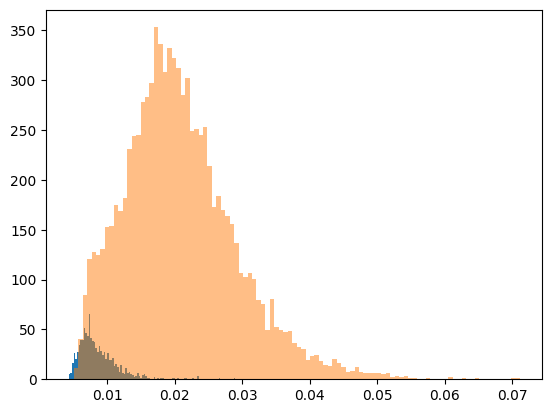

In [96]:
plt.hist(anomaly_score[normaly_idx],bins=100,label='normal')
plt.hist(anomaly_score[anormaly_idx],bins=100,label='anormal',alpha=0.5)
plt.show()

In [118]:
img

torch.Size([16, 1, 28, 28])